In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install tensorflow-addons

In [ ]:
try:
  %tensorflow_version 2.x
  import tensorflow as tf
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))
except:
  pass

## Enabling and testing the TPU

First, you'll need to enable TPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select TPU from the Hardware Accelerator drop-down

Next, we'll check that we can connect to the TPU:

In [ ]:
try:
  %tensorflow_version 2.x
  import tensorflow as tf
  print("Tensorflow version " + tf.__version__)

  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
  pass

Tensorflow version 2.5.0


In [ ]:
import re
import numpy as np
from matplotlib import pyplot as plt

# Import libraries

In [ ]:
#@title Libraries
%pylab inline
import imutils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab
import matplotlib.image as mpimg
from PIL import Image as im
# import segmentation_models_pytorch as smp
import cv2
from google.colab.patches import cv2_imshow
from scipy import ndimage, misc
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import matplotlib.patches as mpatches
from scipy.misc import face
from scipy.signal.signaltools import wiener
import sys
import numpy as np
import skimage.color
import skimage.filters
import skimage.io
import skimage.viewer
from skimage import feature, io, color, filters
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.filters import sobel
from skimage.draw import polygon
from skimage import exposure
from skimage.transform import resize
from PIL import Image
import scipy.ndimage as snd
#from meta-pseudo-labels.


Populating the interactive namespace from numpy and matplotlib


# Mount file syste,

In [ ]:
#@title Driver mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import data

In [ ]:

# import os
# input_dir = "/content/drive/MyDrive/Thesis/MINI-DDSM-Complete-JPEG-8/Data.xlsx"
root = '\\content\\drive\\MyDrive\\Thesis\\MINI-DDSM-Complete-JPEG-8\\'
# dfAll = pd.read_excel(input_dir)
# dfAll.head()

# Selecting and Sampling

In [ ]:
# data = dfAll.loc[(dfAll.Status == 'Benign') & (dfAll.Tumour_Contour != '-')].copy()
# data.reset_index(inplace = True, drop = True)
# Cancer_data = dfAll.loc[(dfAll.Status == 'Cancer') & (dfAll.Tumour_Contour != '-')].copy()
# Cancer_data.reset_index(inplace = True, drop = True)
# Normal_data = dfAll.loc[(dfAll.Status == 'Normal')].copy()
# Normal_data.reset_index(inplace = True, drop = True)
# data = data.append(Cancer_data, ignore_index = True)
# data = data.append(Normal_data, ignore_index = True)
# data = data.sample(frac=1).reset_index(drop=True)
# data.head()to

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Thesis/pos/data.csv')
df_ = pd.read_csv('/content/drive/MyDrive/Thesis/pos/data_p.csv')
dfc_ = pd.read_csv('/content/drive/MyDrive/Thesis/pos/data_c.csv')


# EfficientUnet

## Efficientnet

In [ ]:
#@title Efficientnet
from keras import models, layers
# import sys  
# sys.path.insert(0, '/content/drive/MyDrive/Thesis/MPL/EfficientUnet/efficientunet')
from tensorflow.keras.utils import get_file
# from utils import *

__all__ = ['get_model_by_name', 'get_efficientnet_b0_encoder', 'get_efficientnet_b1_encoder',
           'get_efficientnet_b2_encoder', 'get_efficientnet_b3_encoder', 'get_efficientnet_b4_encoder',
           'get_efficientnet_b5_encoder', 'get_efficientnet_b6_encoder', 'get_efficientnet_b7_encoder']


def _efficientnet(input_shape, blocks_args_list, global_params):
    batch_norm_momentum = global_params.batch_norm_momentum
    batch_norm_epsilon = global_params.batch_norm_epsilon

    # Stem part
    model_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(
        filters=round_filters(32, global_params),
        kernel_size=[3, 3],
        strides=[2, 2],
        kernel_initializer=conv_kernel_initializer,
        padding='same',
        use_bias=False,
        name='stem_conv2d'
    )(model_input)

    x = layers.BatchNormalization(
        momentum=batch_norm_momentum,
        epsilon=batch_norm_epsilon,
        name='stem_batch_norm'
    )(x)

    x = Swish(name='stem_swish')(x)

    # Blocks part
    idx = 0
    drop_rate = global_params.drop_connect_rate
    n_blocks = sum([blocks_args.num_repeat for blocks_args in blocks_args_list])
    drop_rate_dx = drop_rate / n_blocks

    for blocks_args in blocks_args_list:
        assert blocks_args.num_repeat > 0
        # Update block input and output filters based on depth multiplier.
        blocks_args = blocks_args._replace(
            input_filters=round_filters(blocks_args.input_filters, global_params),
            output_filters=round_filters(blocks_args.output_filters, global_params),
            num_repeat=round_repeats(blocks_args.num_repeat, global_params)
        )

        # The first block needs to take care of stride and filter size increase.
        x = MBConvBlock(blocks_args, global_params, idx, drop_connect_rate=drop_rate_dx * idx)(x)
        idx += 1

        if blocks_args.num_repeat > 1:
            blocks_args = blocks_args._replace(input_filters=blocks_args.output_filters, strides=[1, 1])

        for _ in range(blocks_args.num_repeat - 1):
            x = MBConvBlock(blocks_args, global_params, idx, drop_connect_rate=drop_rate_dx * idx)(x)
            idx += 1

    # Head part
    x = layers.Conv2D(
        filters=round_filters(1280, global_params),
        kernel_size=[1, 1],
        strides=[1, 1],
        kernel_initializer=conv_kernel_initializer,
        padding='same',
        use_bias=False,
        name='head_conv2d'
    )(x)

    x = layers.BatchNormalization(
        momentum=batch_norm_momentum,
        epsilon=batch_norm_epsilon,
        name='head_batch_norm'
    )(x)

    x = Swish(name='head_swish')(x)

    x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)

    if global_params.dropout_rate > 0:
        x = layers.Dropout(global_params.dropout_rate)(x)

    x = layers.Dense(
        global_params.num_classes,
        kernel_initializer=dense_kernel_initializer,
        activation='softmax',
        name='head_dense'
    )(x)

    model = models.Model(model_input, x)

    return model


def get_model_by_name(model_name, input_shape, classes=3, pretrained=False):
    """Get an EfficientNet model by its name.
    """
    blocks_args, global_params = get_efficientnet_params(model_name, override_params={'num_classes': classes})
    model = _efficientnet(input_shape, blocks_args, global_params)

    try:
        if pretrained:
            weights = IMAGENET_WEIGHTS[model_name]
            weights_path = get_file(
                weights['name'],
                weights['url'],
                cache_subdir='models',
                md5_hash=weights['md5'],
            )
            model.load_weights(weights_path)
    except KeyError as e:
        print("NOTE: Currently model {} doesn't have pretrained weights, therefore a model with randomly initialized"
              " weights is returned.".format(e))

    return model


def _get_efficientnet_encoder(model_name, input_shape, pretrained=False):
    model = get_model_by_name(model_name, input_shape, pretrained=pretrained)
    encoder = models.Model(model.input, model.get_layer('global_average_pooling2d').output)
    encoder.layers.pop()  # remove GAP layer
    return encoder


def get_efficientnet_b0_encoder(input_shape, pretrained=False):
    return _get_efficientnet_encoder('efficientnet-b0', input_shape, pretrained=pretrained)


def get_efficientnet_b1_encoder(input_shape, pretrained=False):
    return _get_efficientnet_encoder('efficientnet-b1', input_shape, pretrained=pretrained)


def get_efficientnet_b2_encoder(input_shape, pretrained=False):
    return _get_efficientnet_encoder('efficientnet-b2', input_shape, pretrained=pretrained)


def get_efficientnet_b3_encoder(input_shape, pretrained=False):
    return _get_efficientnet_encoder('efficientnet-b3', input_shape, pretrained=pretrained)


def get_efficientnet_b4_encoder(input_shape, pretrained=False):
    return _get_efficientnet_encoder('efficientnet-b4', input_shape, pretrained=pretrained)


def get_efficientnet_b5_encoder(input_shape, pretrained=False):
    return _get_efficientnet_encoder('efficientnet-b5', input_shape, pretrained=pretrained)


def get_efficientnet_b6_encoder(input_shape, pretrained=False):
    return _get_efficientnet_encoder('efficientnet-b6', input_shape, pretrained=pretrained)


def get_efficientnet_b7_encoder(input_shape, pretrained=False):
    return _get_efficientnet_encoder('efficientnet-b7', input_shape, pretrained=pretrained)


## Utils

In [ ]:
#@title number of classes

n_classes=1 #@param {type:"integer"}

In [ ]:
#@title Utils
import re
from collections import namedtuple
from keras import layers
import keras.backend as K
import tensorflow as tf
import math
import numpy as np

GlobalParams = namedtuple('GlobalParams', ['batch_norm_momentum', 'batch_norm_epsilon', 'dropout_rate', 'num_classes',
                                           'width_coefficient', 'depth_coefficient', 'depth_divisor', 'min_depth',
                                           'drop_connect_rate'])
global_params = None
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)

BlockArgs = namedtuple('BlockArgs', ['kernel_size', 'num_repeat', 'input_filters', 'output_filters', 'expand_ratio',
                                     'id_skip', 'strides', 'se_ratio'])
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)

IMAGENET_WEIGHTS = {

    'efficientnet-b0': {
        'name': 'efficientnet-b0_imagenet_1000.h5',
        'url': 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b0_imagenet_1000.h5',
        'md5': 'bca04d16b1b8a7c607b1152fe9261af7',
    },

    'efficientnet-b1': {
        'name': 'efficientnet-b1_imagenet_1000.h5',
        'url': 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b1_imagenet_1000.h5',
        'md5': 'bd4a2b82f6f6bada74fc754553c464fc',
    },

    'efficientnet-b2': {
        'name': 'efficientnet-b2_imagenet_1000.h5',
        'url': 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b2_imagenet_1000.h5',
        'md5': '45b28b26f15958bac270ab527a376999',
    },

    'efficientnet-b3': {
        'name': 'efficientnet-b3_imagenet_1000.h5',
        'url': 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b3_imagenet_1000.h5',
        'md5': 'decd2c8a23971734f9d3f6b4053bf424',
    },

    'efficientnet-b4': {
        'name': 'efficientnet-b4_imagenet_1000.h5',
        'url': 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b4_imagenet_1000.h5',
        'md5': '01df77157a86609530aeb4f1f9527949',
    },

    'efficientnet-b5': {
        'name': 'efficientnet-b5_imagenet_1000.h5',
        'url': 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/efficientnet-b5_imagenet_1000.h5',
        'md5': 'c31311a1a38b5111e14457145fccdf32',
    }

}


def round_filters(filters, global_params):
    """Round number of filters."""
    multiplier = global_params.width_coefficient
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    if not multiplier:
        return filters

    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """Round number of repeats."""
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


def get_efficientnet_params(model_name, override_params=None):
    """Get efficientnet params based on model name."""
    params_dict = {
        # (width_coefficient, depth_coefficient, resolution, dropout_rate)
        # Note: the resolution here is just for reference, its values won't be used.
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
    }
    if model_name not in params_dict.keys():
        raise KeyError('There is no model named {}.'.format(model_name))

    width_coefficient, depth_coefficient, _, dropout_rate = params_dict[model_name]

    blocks_args = [
        'r1_k3_s11_e1_i32_o16_se0.25', 'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25', 'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25', 'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]
    global_params = GlobalParams(
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        dropout_rate=dropout_rate,
        drop_connect_rate=0.2,
        num_classes=n_classes,
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        depth_divisor=8,
        min_depth=None)

    if override_params:
        global_params = global_params._replace(**override_params)

    decoder = BlockDecoder()
    return decoder.decode(blocks_args), global_params


class BlockDecoder(object):
    """Block Decoder for readability."""

    @staticmethod
    def _decode_block_string(block_string):
        """Gets a block through a string notation of arguments."""
        assert isinstance(block_string, str)
        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        if 's' not in options or len(options['s']) != 2:
            raise ValueError('Strides options should be a pair of integers.')

        return BlockArgs(
            kernel_size=int(options['k']),
            num_repeat=int(options['r']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            expand_ratio=int(options['e']),
            id_skip=('noskip' not in block_string),
            se_ratio=float(options['se']) if 'se' in options else None,
            strides=[int(options['s'][0]), int(options['s'][1])]
        )

    @staticmethod
    def _encode_block_string(block):
        """Encodes a block to a string."""
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.strides[0], block.strides[1]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    def decode(self, string_list):
        """Decodes a list of string notations to specify blocks inside the network.
        Args:
          string_list: a list of strings, each string is a notation of block.
        Returns:
          A list of namedtuples to represent blocks arguments.
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(self._decode_block_string(block_string))
        return blocks_args

    def encode(self, blocks_args):
        """Encodes a list of Blocks to a list of strings.
        Args:
          blocks_args: A list of namedtuples to represent blocks arguments.
        Returns:
          a list of strings, each string is a notation of block.
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(self._encode_block_string(block))
        return block_strings


class Swish(layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, inputs, **kwargs):
        return tf.nn.silu(inputs)#tf.nn.swish I have changed this why I don't know yet

    def get_config(self):
        config = super().get_config()
        config['name'] = self.name
        return config


def SEBlock(block_args, **kwargs):
    num_reduced_filters = max(
        1, int(block_args.input_filters * block_args.se_ratio))
    filters = block_args.input_filters * block_args.expand_ratio

    spatial_dims = [1, 2]

    try:
        block_name = kwargs['block_name']
    except KeyError:
        block_name = ''

    def block(inputs):
        x = inputs
        x = layers.Lambda(lambda a: K.mean(a, axis=spatial_dims, keepdims=True))(x)
        x = layers.Conv2D(
            num_reduced_filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer=conv_kernel_initializer,
            padding='same',
            name=block_name + 'se_reduce_conv2d',
            use_bias=True
        )(x)

        x = Swish(name=block_name + 'se_swish')(x)

        x = layers.Conv2D(
            filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer=conv_kernel_initializer,
            padding='same',
            name=block_name + 'se_expand_conv2d',
            use_bias=True
        )(x)

        x = layers.Activation('sigmoid')(x)
        out = layers.Multiply()([x, inputs])
        return out

    return block


class DropConnect(layers.Layer):

    def __init__(self, drop_connect_rate, **kwargs):
        super().__init__(**kwargs)
        self.drop_connect_rate = drop_connect_rate

    def call(self, inputs, **kwargs):
        def drop_connect():
            keep_prob = 1.0 - self.drop_connect_rate

            # Compute drop_connect tensor
            batch_size = tf.shape(inputs)[0]
            random_tensor = keep_prob
            random_tensor += tf.random.uniform([batch_size, 1, 1, 1], dtype=inputs.dtype)
            binary_tensor = tf.floor(random_tensor)
            output = tf.math.divide(inputs, keep_prob) * binary_tensor
            return output

        return K.in_train_phase(drop_connect(), inputs, training=None)

    def get_config(self):
        config = super().get_config()
        config['drop_connect_rate'] = self.drop_connect_rate
        return config


def conv_kernel_initializer(shape, dtype=K.floatx()):
    """Initialization for convolutional kernels.
    The main difference with tf.variance_scaling_initializer is that
    tf.variance_scaling_initializer uses a truncated normal with an uncorrected
    standard deviation, whereas here we use a normal distribution. Similarly,
    tf.contrib.layers.variance_scaling_initializer uses a truncated normal with
    a corrected standard deviation.
    Args:
        shape: shape of variable
        dtype: dtype of variable
    Returns:
        an initialization for the variable
    """
    kernel_height, kernel_width, _, out_filters = shape
    fan_out = int(kernel_height * kernel_width * out_filters)
    return tf.random.normal(
        shape, mean=0.0, stddev=np.sqrt(2.0 / fan_out), dtype=dtype)


def dense_kernel_initializer(shape, dtype=K.floatx()):
    init_range = 1.0 / np.sqrt(shape[1])
    return tf.random.uniform(shape, -init_range, init_range, dtype=dtype)


def MBConvBlock(block_args, global_params, idx, drop_connect_rate=None):
    filters = block_args.input_filters * block_args.expand_ratio
    batch_norm_momentum = global_params.batch_norm_momentum
    batch_norm_epsilon = global_params.batch_norm_epsilon
    has_se = (block_args.se_ratio is not None) and (0 < block_args.se_ratio <= 1)

    block_name = 'blocks_' + str(idx) + '_'

    def block(inputs):
        x = inputs

        # Expansion phase
        if block_args.expand_ratio != 1:
            expand_conv = layers.Conv2D(filters,
                                        kernel_size=[1, 1],
                                        strides=[1, 1],
                                        kernel_initializer=conv_kernel_initializer,
                                        padding='same',
                                        use_bias=False,
                                        name=block_name + 'expansion_conv2d'
                                        )(x)
            bn0 = layers.BatchNormalization(momentum=batch_norm_momentum,
                                            epsilon=batch_norm_epsilon,
                                            name=block_name + 'expansion_batch_norm')(expand_conv)

            x = Swish(name=block_name + 'expansion_swish')(bn0)

        # Depth-wise convolution phase
        kernel_size = block_args.kernel_size
        depthwise_conv = layers.DepthwiseConv2D(
            [kernel_size, kernel_size],
            strides=block_args.strides,
            depthwise_initializer=conv_kernel_initializer,
            padding='same',
            use_bias=False,
            name=block_name + 'depthwise_conv2d'
        )(x)
        bn1 = layers.BatchNormalization(momentum=batch_norm_momentum,
                                        epsilon=batch_norm_epsilon,
                                        name=block_name + 'depthwise_batch_norm'
                                        )(depthwise_conv)
        x = Swish(name=block_name + 'depthwise_swish')(bn1)

        if has_se:
            x = SEBlock(block_args, block_name=block_name)(x)

        # Output phase
        project_conv = layers.Conv2D(
            block_args.output_filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer=conv_kernel_initializer,
            padding='same',
            name=block_name + 'output_conv2d',
            use_bias=False)(x)
        x = layers.BatchNormalization(momentum=batch_norm_momentum,
                                      epsilon=batch_norm_epsilon,
                                      name=block_name + 'output_batch_norm'
                                      )(project_conv)
        if block_args.id_skip:
            if all(
                    s == 1 for s in block_args.strides
            ) and block_args.input_filters == block_args.output_filters:
                # only apply drop_connect if skip presents.
                if drop_connect_rate:
                    x = DropConnect(drop_connect_rate)(x)
                x = layers.add([x, inputs])

        return x

    return block


def freeze_efficientunet_first_n_blocks(model, n):
    mbblock_nr = 0
    while True:
        try:
            model.get_layer('blocks_{}_output_batch_norm'.format(mbblock_nr))
            mbblock_nr += 1
        except ValueError:
            break

    all_block_names = ['blocks_{}_output_batch_norm'.format(i) for i in range(mbblock_nr)]
    all_block_index = []
    for idx, layer in enumerate(model.layers):
        if layer.name == all_block_names[0]:
            all_block_index.append(idx)
            all_block_names.pop(0)
            if len(all_block_names) == 0:
                break
    n_blocks = len(all_block_index)

    if n <= 0:
        print('n is less than or equal to 0, therefore no layer will be frozen.')
        return
    if n > n_blocks:
        raise ValueError("There are {} blocks in total, n cannot be greater than {}.".format(n_blocks, n_blocks))

    idx_of_last_block_to_be_frozen = all_block_index[n - 1]
    for layer in model.layers[:idx_of_last_block_to_be_frozen + 1]:
        layer.trainable = False


def unfreeze_efficientunet(model):
    for layer in model.layers:
        layer.trainable = True


## *Efficientunet*

In [ ]:
#@markdown Efficientnet-unet
import sys  
# sys.path.insert(0, '/content/drive/MyDrive/Thesis/MPL/EfficientUnet/efficientunet')
from keras.layers import *
from keras import models
# from efficientnet import *
# from utils import conv_kernel_initializer


__all__ = ['get_efficient_unet_b0', 'get_efficient_unet_b1', 'get_efficient_unet_b2', 'get_efficient_unet_b3',
           'get_efficient_unet_b4', 'get_efficient_unet_b5', 'get_efficient_unet_b6', 'get_efficient_unet_b7',
           'get_blocknr_of_skip_candidates']


def get_blocknr_of_skip_candidates(encoder, verbose=False):
    """
    Get block numbers of the blocks which will be used for concatenation in the Unet.
    :param encoder: the encoder
    :param verbose: if set to True, the shape information of all blocks will be printed in the console
    :return: a list of block numbers
    """
    shapes = []
    candidates = []
    mbblock_nr = 0
    while True:
        try:
            mbblock = encoder.get_layer('blocks_{}_output_batch_norm'.format(mbblock_nr)).output
            shape = int(mbblock.shape[1]), int(mbblock.shape[2])
            if shape not in shapes:
                shapes.append(shape)
                candidates.append(mbblock_nr)
            if verbose:
                print('blocks_{}_output_shape: {}'.format(mbblock_nr, shape))
            mbblock_nr += 1
        except ValueError:
            break
    return candidates


def DoubleConv(filters, kernel_size, initializer='glorot_uniform'):

    def layer(x):

        x = Conv2D(filters, kernel_size, padding='same', use_bias=False, kernel_initializer=initializer)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size, padding='same', use_bias=False, kernel_initializer=initializer)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        return x

    return layer


def UpSampling2D_block(filters, kernel_size=(3, 3), upsample_rate=(2, 2), interpolation='bilinear',
                       initializer='glorot_uniform', skip=None):
    def layer(input_tensor):

        x = UpSampling2D(size=upsample_rate, interpolation=interpolation)(input_tensor)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = DoubleConv(filters, kernel_size, initializer=initializer)(x)

        return x
    return layer


def Conv2DTranspose_block(filters, kernel_size=(3, 3), transpose_kernel_size=(2, 2), upsample_rate=(2, 2),
                          initializer='glorot_uniform', skip=None):
    def layer(input_tensor):

        x = Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_rate, padding='same')(input_tensor)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = DoubleConv(filters, kernel_size, initializer=initializer)(x)

        return x

    return layer


# noinspection PyTypeChecker
def _get_efficient_unet(encoder, out_channels=2, block_type='upsampling', concat_input=True):
    MBConvBlocks = []

    skip_candidates = get_blocknr_of_skip_candidates(encoder)

    for mbblock_nr in skip_candidates:
        mbblock = encoder.get_layer('blocks_{}_output_batch_norm'.format(mbblock_nr)).output
        MBConvBlocks.append(mbblock)

    # delete the last block since it won't be used in the process of concatenation
    MBConvBlocks.pop()

    input_ = encoder.input
    head = encoder.get_layer('head_swish').output
    blocks = [input_] + MBConvBlocks + [head]

    if block_type == 'upsampling':
        UpBlock = UpSampling2D_block
    else:
        UpBlock = Conv2DTranspose_block

    o = blocks.pop()
    o = UpBlock(512, initializer=conv_kernel_initializer, skip=blocks.pop())(o)
    o = UpBlock(256, initializer=conv_kernel_initializer, skip=blocks.pop())(o)
    o = UpBlock(128, initializer=conv_kernel_initializer, skip=blocks.pop())(o)
    o = UpBlock(64, initializer=conv_kernel_initializer, skip=blocks.pop())(o)
    if concat_input:
        o = UpBlock(32, initializer=conv_kernel_initializer, skip=blocks.pop())(o)
    else:
        o = UpBlock(32, initializer=conv_kernel_initializer, skip=None)(o)
    o = Conv2D(out_channels, (1, 1), padding='same', kernel_initializer=conv_kernel_initializer)(o)

    model = models.Model(encoder.input, o)

    return model


def get_efficient_unet_b0(input_shape, out_channels=2, pretrained=False, block_type='transpose', concat_input=True):
    """Get a Unet model with Efficient-B0 encoder
    :param input_shape: shape of input (cannot have None element)
    :param out_channels: the number of output channels
    :param pretrained: True for ImageNet pretrained weights
    :param block_type: "upsampling" to use UpSampling layer, otherwise use Conv2DTranspose layer
    :param concat_input: if True, input image will be concatenated with the last conv layer
    :return: an EfficientUnet_B0 model
    """
    encoder = get_efficientnet_b0_encoder(input_shape, pretrained=pretrained)
    model = _get_efficient_unet(encoder, out_channels, block_type=block_type, concat_input=concat_input)
    return model


def get_efficient_unet_b1(input_shape, out_channels=2, pretrained=False, block_type='transpose', concat_input=True):
    """Get a Unet model with Efficient-B1 encoder
    :param input_shape: shape of input (cannot have None element)
    :param out_channels: the number of output channels
    :param pretrained: True for ImageNet pretrained weights
    :param block_type: "upsampling" to use UpSampling layer, otherwise use Conv2DTranspose layer
    :param concat_input: if True, input image will be concatenated with the last conv layer
    :return: an EfficientUnet_B1 model
    """
    encoder = get_efficientnet_b1_encoder(input_shape, pretrained=pretrained)
    model = _get_efficient_unet(encoder, out_channels, block_type=block_type, concat_input=concat_input)
    return model


def get_efficient_unet_b2(input_shape, out_channels=2, pretrained=False, block_type='transpose', concat_input=True):
    """Get a Unet model with Efficient-B2 encoder
    :param input_shape: shape of input (cannot have None element)
    :param out_channels: the number of output channels
    :param pretrained: True for ImageNet pretrained weights
    :param block_type: "upsampling" to use UpSampling layer, otherwise use Conv2DTranspose layer
    :param concat_input: if True, input image will be concatenated with the last conv layer
    :return: an EfficientUnet_B2 model
    """
    encoder = get_efficientnet_b2_encoder(input_shape, pretrained=pretrained)
    model = _get_efficient_unet(encoder, out_channels, block_type=block_type, concat_input=concat_input)
    return model


def get_efficient_unet_b3(input_shape, out_channels=2, pretrained=False, block_type='transpose', concat_input=True):
    """Get a Unet model with Efficient-B3 encoder
    :param input_shape: shape of input (cannot have None element)
    :param out_channels: the number of output channels
    :param pretrained: True for ImageNet pretrained weights
    :param block_type: "upsampling" to use UpSampling layer, otherwise use Conv2DTranspose layer
    :param concat_input: if True, input image will be concatenated with the last conv layer
    :return: an EfficientUnet_B3 model
    """
    encoder = get_efficientnet_b3_encoder(input_shape, pretrained=pretrained)
    model = _get_efficient_unet(encoder, out_channels, block_type=block_type, concat_input=concat_input)
    return model


def get_efficient_unet_b4(input_shape, out_channels=2, pretrained=False, block_type='transpose', concat_input=True):
    """Get a Unet model with Efficient-B4 encoder
    :param input_shape: shape of input (cannot have None element)
    :param out_channels: the number of output channels
    :param pretrained: True for ImageNet pretrained weights
    :param block_type: "upsampling" to use UpSampling layer, otherwise use Conv2DTranspose layer
    :param concat_input: if True, input image will be concatenated with the last conv layer
    :return: an EfficientUnet_B4 model
    """
    encoder = get_efficientnet_b4_encoder(input_shape, pretrained=pretrained)
    model = _get_efficient_unet(encoder, out_channels, block_type=block_type, concat_input=concat_input)
    return model


def get_efficient_unet_b5(input_shape, out_channels=2, pretrained=False, block_type='transpose', concat_input=True):
    """Get a Unet model with Efficient-B5 encoder
    :param input_shape: shape of input (cannot have None element)
    :param out_channels: the number of output channels
    :param pretrained: True for ImageNet pretrained weights
    :param block_type: "upsampling" to use UpSampling layer, otherwise use Conv2DTranspose layer
    :param concat_input: if True, input image will be concatenated with the last conv layer
    :return: an EfficientUnet_B5 model
    """
    encoder = get_efficientnet_b5_encoder(input_shape, pretrained=pretrained)
    model = _get_efficient_unet(encoder, out_channels, block_type=block_type, concat_input=concat_input)
    return model


def get_efficient_unet_b6(input_shape, out_channels=2, pretrained=False, block_type='transpose', concat_input=True):
    """Get a Unet model with Efficient-B6 encoder
    :param input_shape: shape of input (cannot have None element)
    :param out_channels: the number of output channels
    :param pretrained: True for ImageNet pretrained weights
    :param block_type: "upsampling" to use UpSampling layer, otherwise use Conv2DTranspose layer
    :param concat_input: if True, input image will be concatenated with the last conv layer
    :return: an EfficientUnet_B6 model
    """
    encoder = get_efficientnet_b6_encoder(input_shape, pretrained=pretrained)
    model = _get_efficient_unet(encoder, out_channels, block_type=block_type, concat_input=concat_input)
    return model


def get_efficient_unet_b7(input_shape, out_channels=2, pretrained=False, block_type='transpose', concat_input=True):
    """Get a Unet model with Efficient-B7 encoder
    :param input_shape: shape of input (cannot have None element)
    :param out_channels: the number of output channels
    :param pretrained: True for ImageNet pretrained weights
    :param block_type: "upsampling" to use UpSampling layer, otherwise use Conv2DTranspose layer
    :param concat_input: if True, input image will be concatenated with the last conv layer
    :return: an EfficientUnet_B7 model
    """
    encoder = get_efficientnet_b7_encoder(input_shape, pretrained=pretrained)
    model = _get_efficient_unet(encoder, out_channels, block_type=block_type, concat_input=concat_input)
    return model


## Create model

In [ ]:
Channels =  3#@param {type:"integer"}
Img_size = 448#@param {type:"integer"}
input_shape = (Img_size, Img_size, Channels) 

In [ ]:
tf.keras.backend.clear_session()


In [ ]:
#@markdown Model Efficient unet

classifier =  get_efficient_unet_b5(input_shape, out_channels=1, pretrained=False, block_type='transpose', concat_input=True)
classifier.summary()

In [ ]:
#@markdown Model Efficient unet teacher

classifiert =  get_efficient_unet_b5(input_shape, out_channels=1, pretrained=False, block_type='transpose', concat_input=True)
classifiert.summary()

# Model

In [ ]:
#@title MPL config

import tensorflow as tf




# about dataset
IMG_SIZE = 448#@param {type:"integer"}
BATCH_SIZE = 2
# LABEL_FILE_PATH = '/content/cifar/label4000.csv' # google
# UNLABEL_FILE_PATH = '/content/cifar/train.csv'

_MAX_LEVEL = 10
CUTOUT_CONST = 40.
TRANSLATE_CONST = 100.
REPLACE_COLOR = [128, 128, 128]


# LABEL_FILE_PATH = '../input/cifar10/cifar/label4000.csv'  # kaggle
# UNLABEL_FILE_PATH = '../input/cifar10/cifar/train.csv'


AUGMENT_MAGNITUDE = 8
SHUFFLE_SIZE = BATCH_SIZE * 16
DATA_LEN = 400  # 数据集的总长度

# about model
NUM_XLA_SHARDS = -1
BATCH_NORM_EPSILON = 1e-3
BATCH_NORM_DECAY = 0.999
DROPOUT_RATE = 0.
DROPOUT = 0.2
NUM_CLASSES = 1#@param {type:"integer"}
NUM_CLASS = 1#@param {type:"integer"}

# about training
LOG_EVERY = 20
SAVE_EVERY = 5
TEA_SAVE_PATH = '/content/drive/MyDrive/Thesis/weights/ST'
STD_SAVE_PATH = '/content/drive/MyDrive/Thesis/weights/SS'

MAX_EPOCHS = 1920
MAX_STEPS = MAX_EPOCHS * (int(DATA_LEN / BATCH_SIZE)-1)
UDA_WEIGHT = 8  # uda的权重
UDA_STEPS = 2000
TEST_EVERY = 2
GRAD_BOUND = 1e9
EMA = 0.995


# continue train
TEA_CONTINUE = True
STD_CONTINUE = True
TEA_LOAD_PATH = '/content/drive/MyDrive/Thesis/weights/ST'
STD_LOAD_PATH = '/content/drive/MyDrive/Thesis/weights/SS'
CONTINUE_EPOCH = 885


# about testing
# TEST_FILE_PATH = '/content/cifar/test.csv'
# TEST_FILE_PATH = '../input/cifar10/cifar/test.csv'
TEST_MODEL_PATH = '/content/drive/MyDrive/Thesis/weights/SS'

# about UdaCrossEntroy
UDA_DATA = 1
LABEL_SMOOTHING = 0.15
UDA_TEMP = 0.7
UDA_THRESHOLD = 0.6

# about learning rate
STUDENT_LR = 0.0005  # student
STUDENT_LR_WARMUP_STEPS = 4000
STUDENT_LR_WAIT_STEPS = 2000
TEACHER_LR = 0.0005  # teacher
TEACHER_LR_WARMUP_STEPS = 1000
TEACHER_NUM_WAIT_STEPS = 0

LR_DECAY_TYPE = 'cosine'  # constant, exponential, cosine
NUM_DECAY_STEPS = 300
LR_DECAY_RATE = 0.97

# about optimizer
OPTIM_TYPE = 'sgd'  # sgd, momentum, rmsprop
WEIGHT_DECAY = 5e-4


# dtype
DTYPE = tf.float32

In [ ]:
#@title Self_aug_func
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import matplotlib.pyplot as plt
import math
import tensorflow_addons.image as image_ops

# import 


def autocontrast(image):
    lo = tf.cast(tf.reduce_min(image, axis=[0, 1]), tf.float32)
    hi = tf.cast(tf.reduce_max(image, axis=[0, 1]), tf.float32)
    scale = tf.math.divide(255.0, (hi - lo))
    offset = tf.math.multiply(-lo, scale)
    image = tf.math.add(
        tf.math.multiply(tf.cast(image, tf.float32), scale),
        offset
    )
    image = tf.clip_by_value(image, 0.0, 255.0)
    image = tf.cast(image, tf.uint8)
    return image


def equalize(image):
    # image = tf.cast(image, tf.int32)
    # channel = tf.shape(image)[-1]
    # for i in range(channel):
    #     im = tf.cast(image[:, :, i], tf.int32)
    #     histo = tf.histogram_fixed_width(im, [0, 255], nbins=256)
    #     nonzero = tf.where(tf.not_equal(histo, 0))
    #     nonzero_histo = tf.reshape(tf.gather(histo, nonzero), [-1])
    #     step = (tf.reduce_sum(nonzero_histo) - nonzero_histo[-1]) // 255
    #     print(step)
    #     if step == 0:
    #         pass
    #     else:
    #         lut = (tf.cumsum(histo) + (step // 2)) // step
    #         lut = tf.concat([[0], lut[:-1]], 0)
    #         lut = tf.clip_by_value(lut, 0, 255)
    #         # print(lut)
    #         image[:, :, i] = tf.gather(lut, image[:, :, i])
    #         # image[:, :, i] = im
    #     # image[:, :, i] = im

    def scale_channel(im, c=0):
        """Scale the data in the channel to implement equalize."""
        im = tf.cast(im[:, :, 0], tf.int32)
        # Compute the histogram of the image channel.
        histo = tf.histogram_fixed_width(im, [0, 255], nbins=256)

        # For the purposes of computing the step, filter out the nonzeros.
        nonzero = tf.where(tf.not_equal(histo, 0))
        nonzero_histo = tf.reshape(tf.gather(histo, nonzero), [-1])
        step = (tf.reduce_sum(nonzero_histo) - nonzero_histo[-1]) // 255

        def build_lut(histo, step):
            # Compute the cumulative sum, shifting by step // 2
            # and then normalization by step.
            lut = (tf.cumsum(histo) + (step // 2)) // step
            # Shift lut, prepending with 0.
            lut = tf.concat([[0], lut[:-1]], 0)
            # Clip the counts to be in range.  This is done
            # in the C code for image.point.
            return tf.clip_by_value(lut, 0, 255)

        # If step is zero, return the original image.  Otherwise, build
        # lut from the full histogram and step and then index from it.
        result = tf.cond(tf.equal(step, 0),
                         lambda: im,
                         lambda: tf.gather(build_lut(histo, step), im))
        return tf.cast(result, tf.uint8)

    s1 = scale_channel(image, 0)
    s2 = scale_channel(image, 1)
    s3 = scale_channel(image, 2)
    image = tf.stack([s1, s2, s3], 2)

    return image


def invert(image):
    image = 255 - image
    return image


def rotate(image):
    level = tf.convert_to_tensor((AUGMENT_MAGNITUDE / _MAX_LEVEL) * 30, tf.float32)
    should_filp = tf.cast(
        tf.floor(tf.random.uniform([]) + 0.5),
        tf.bool
    )
    degree = tf.cond(should_filp, lambda: level, lambda: -level)
    degree_to_radians = tf.convert_to_tensor(math.pi / 180., tf.float32)
    radians = tf.math.multiply(degree, degree_to_radians)
    new_imgsize = tf.cast(tf.math.abs(tf.divide(IMG_SIZE, radians)), tf.int32)
    image = tf.image.resize(image, (new_imgsize, new_imgsize))
    image = image_ops.rotate(image, radians, fill_mode='constant')
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE, IMG_SIZE)
    image = tf.cast(image, tf.uint8)
    return image


def posterize(image):
    bit = tf.cast(tf.cast(AUGMENT_MAGNITUDE, tf.float32) / _MAX_LEVEL * 4, tf.float32)
    shift = tf.cast(8 - bit, image.dtype)
    image = tf.bitwise.right_shift(image, shift)
    image = tf.bitwise.left_shift(image, shift)
    return image


def solarize_arg(image):
    threahold = tf.cast(tf.cast(AUGMENT_MAGNITUDE, tf.float32) / _MAX_LEVEL * 22, tf.float32)
    threahold = tf.cast(threahold, image.dtype)
    image = tf.where(image < threahold, image, 255 - image)
    return image


def solarize_add(image, threahold=128):
    addition = tf.cast(tf.cast(AUGMENT_MAGNITUDE, tf.float32) / _MAX_LEVEL * 2, tf.int32)
    threahold = tf.cast(threahold, image.dtype)
    image = tf.add(tf.cast(image, tf.int32), addition)
    image = tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8)
    image = tf.where(image < threahold, image, 255 - image)
    return image


def color(image, degenetate=None):
    if degenetate is None:
        degenerate = tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(image))

    factor = tf.cast((AUGMENT_MAGNITUDE / _MAX_LEVEL) * 1.8 + 0.1, tf.float32)

    def _blend():
        degen = tf.image.convert_image_dtype(degenerate, tf.float32)
        img = tf.image.convert_image_dtype(image, tf.float32)
        output = degen + factor * (img - degen)
        output = tf.where(
            tf.logical_and(tf.less(0., factor), tf.less(factor, 1.)),
            x=output,
            y=tf.clip_by_value(output, 0., 255.)
        )
        return tf.image.convert_image_dtype(output, tf.uint8)

    pred_fn_pairs = [
        (tf.equal(factor, 0.), lambda: degenerate),
        (tf.equal(factor, 1.), lambda: image),
    ]
    image = tf.case(
        pred_fn_pairs=pred_fn_pairs,
        default=_blend,
        exclusive=True,
        strict=True,
    )
    return image


def contrast(image):
    degenerate = tf.image.rgb_to_grayscale(image)
    degenerate = tf.cast(degenerate, tf.int32)

    hist = tf.histogram_fixed_width(degenerate, [0, 255], nbins=256)
    mean = tf.reduce_sum(tf.cast(hist, tf.float32)) / 256.
    degenerate = tf.ones_like(degenerate, dtype=tf.float32) * mean
    degenerate = tf.clip_by_value(degenerate, 0., 255.)
    degenerate = tf.image.grayscale_to_rgb(tf.cast(degenerate, tf.uint8))

    factor = tf.cast((AUGMENT_MAGNITUDE / _MAX_LEVEL) * 0.6 + 0.1, tf.float32)

    def _blend():
        degen = tf.image.convert_image_dtype(degenerate, tf.float32)
        img = tf.image.convert_image_dtype(image, tf.float32)
        output = degen + factor * (img - degen)
        output = tf.where(
            tf.logical_and(tf.less(0., factor), tf.less(factor, 1.)),
            x=output,
            y=tf.clip_by_value(output, 0., 255.)
        )
        return tf.image.convert_image_dtype(output, tf.uint8)

    pred_fn_pairs = [
        (tf.equal(factor, 0.), lambda: degenerate),
        (tf.equal(factor, 1.), lambda: image),
    ]
    image = tf.case(
        pred_fn_pairs=pred_fn_pairs,
        default=_blend,
        exclusive=True,
        strict=True,
    )
    return image


def brightness(image):
    image = tf.image.adjust_brightness(image, 0.25)
    return image


def sharpness(image):
    factor = tf.cast((AUGMENT_MAGNITUDE / _MAX_LEVEL) * 1.6 + 0.1, tf.float32)
    image = tf.cast(image, tf.float32)
    image = image_ops.sharpness(image, factor)
    image = tf.cast(image, tf.uint8)
    return image


def shear_x(image):
    level = tf.convert_to_tensor((AUGMENT_MAGNITUDE / _MAX_LEVEL) * 0.2, tf.float32)
    should_filp = tf.cast(
        tf.floor(tf.random.uniform([]) + 0.5),
        tf.bool
    )
    level = tf.cond(should_filp, lambda: level, lambda: -level)

    new_size = tf.cast(IMG_SIZE * 1.2, dtype=tf.int32)
    image = tf.image.resize(image, (new_size, new_size))
    image = image_ops.shear_x(
        image,
        level,
        replace=tf.convert_to_tensor(REPLACE_COLOR, image.dtype)
    )
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE, IMG_SIZE)
    image = tf.cast(image, tf.uint8)
    return image


def shear_y(image):
    level = tf.convert_to_tensor((AUGMENT_MAGNITUDE / _MAX_LEVEL) * 0.2, tf.float32)
    should_filp = tf.cast(
        tf.floor(tf.random.uniform([]) + 0.5),
        tf.bool
    )
    level = tf.cond(should_filp, lambda: level, lambda: -level)

    new_size = tf.cast(IMG_SIZE * 1.1, dtype=tf.int32)
    image = tf.image.resize(image, (new_size, new_size))
    image = image_ops.shear_y(
        image,
        level,
        replace=tf.convert_to_tensor(REPLACE_COLOR, image.dtype)
    )
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE, IMG_SIZE)
    image = tf.cast(image, tf.uint8)
    return image


def translate_x(image):
    level = tf.convert_to_tensor(
        (AUGMENT_MAGNITUDE / _MAX_LEVEL) * float(TRANSLATE_CONST), tf.float32)
    should_flip = tf.cast(
        tf.floor(tf.random.uniform([]) + 0.5),
        tf.bool)  # 得到的结果为True和False
    pixels = tf.cond(should_flip, lambda: level, lambda: -level)
    image = image_ops.translate(image, [-pixels, 0])
    return image


def translate_y(image):
    level = tf.convert_to_tensor(
        (AUGMENT_MAGNITUDE / _MAX_LEVEL) * float(TRANSLATE_CONST), tf.float32)
    should_flip = tf.cast(
        tf.floor(tf.random.uniform([]) + 0.5),
        tf.bool)  # 得到的结果为True和False
    pixels = tf.cond(should_flip, lambda: level, lambda: -level)
    image = image_ops.translate(image, [0, -pixels])
    return image


def cutout(image):
    pad_size = tf.cast(
        tf.cast(AUGMENT_MAGNITUDE, tf.float32) / _MAX_LEVEL * CUTOUT_CONST,
        tf.int32
    )
    image_height = tf.shape(image)[0]
    image_width = tf.shape(image)[1]

    # Samples the center location in the image where the zero mask is applied.
    cutout_center_height = tf.random.uniform(
        shape=[], minval=0, maxval=image_height,
        dtype=tf.int32)

    cutout_center_width = tf.random.uniform(
        shape=[], minval=0, maxval=image_width,
        dtype=tf.int32)

    lower_pad = tf.maximum(0, cutout_center_height - pad_size)
    upper_pad = tf.maximum(0, image_height - cutout_center_height - pad_size)
    left_pad = tf.maximum(0, cutout_center_width - pad_size)
    right_pad = tf.maximum(0, image_width - cutout_center_width - pad_size)

    cutout_shape = [image_height - (lower_pad + upper_pad),
                    image_width - (left_pad + right_pad)]
    padding_dims = [[lower_pad, upper_pad], [left_pad, right_pad]]
    mask = tf.pad(
        tf.zeros(cutout_shape, dtype=image.dtype),
        padding_dims, constant_values=1)
    mask = tf.expand_dims(mask, -1)
    mask = tf.tile(mask, [1, 1, 3])
    image = tf.where(
        tf.equal(mask, 0),
        tf.ones_like(image, dtype=image.dtype) * REPLACE_COLOR,
        image)
    return image


def identity(image):
    return tf.identity(image)


In [ ]:
#@title Self_aug_util
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

# from self_aug_func import *

_MAX_LEVEL = 10



def _enhance_level_to_arg(level):
    return (tf.cast((level / _MAX_LEVEL) * 1.8 + 0.1, tf.float32),)


def _translate_level_to_arg(level, translate_const):
    level = tf.convert_to_tensor((level / _MAX_LEVEL) * float(translate_const), tf.float32)
    should_flip = tf.cast(
        tf.floor(tf.random.uniform([]) + 0.5),
        tf.bool)  # 得到的结果为True和False
    final_tensor = tf.cond(should_flip, lambda: level, lambda: -level)
    return final_tensor


def _rotate_level_to_arg(level):
    level = tf.convert_to_tensor((level / _MAX_LEVEL) * 30, tf.float32)
    should_filp = tf.cast(
        tf.floor(tf.random.uniform([]) + 0.5),
        tf.bool
    )
    final_tensor = tf.cond(should_filp, lambda: level, lambda: -level)
    return final_tensor


def _shear_level_to_arg(level):
    level = tf.convert_to_tensor((level / _MAX_LEVEL) * 0.3, tf.float32)
    should_filp = tf.cast(
        tf.floor(tf.random.uniform([]) + 0.5),
        tf.bool
    )
    final_tensor = tf.cond(should_filp, lambda: level, lambda: -level)
    return final_tensor


def level_to_arg(cutout_const, translate_const):
    '''
    将对image做变化的函数所用到的参数整理成字典形式
    :param cutout_const:
    :param translate_const:
    :return: type:dict
    '''
    no_arg = lambda level: ()
    posterize_arg = lambda level: tf.cast(
        tf.cast(level, tf.float32) / _MAX_LEVEL * 4,
        tf.float32
    )
    solarize_arg = lambda level: tf.cast(
        tf.cast(level, tf.float32) / _MAX_LEVEL * 256,
        tf.float32
    )
    solarize_add_arg = lambda level: tf.cast(
        tf.cast(level, tf.float32) / _MAX_LEVEL * 110,
        tf.float32
    )
    cutout_arg = lambda level: tf.cast(
        tf.cast(level, tf.float32) / _MAX_LEVEL * cutout_const,
        tf.float32
    )
    translate_arg = lambda level: _translate_level_to_arg(level, translate_const)

    args = {
        'Identity': no_arg,
        'AutoContrast': no_arg,
        'Equalize': no_arg,
        'Invert': no_arg,
        'Rotate': _rotate_level_to_arg,
        'Posterize': posterize_arg,
        'Solarize': solarize_arg,
        'SplarizeAdd': solarize_add_arg,
        'Color': _enhance_level_to_arg,
        'Contrast': _enhance_level_to_arg,
        'Brightness': _enhance_level_to_arg,
        'Sharpness': _enhance_level_to_arg,
        'ShearX': _shear_level_to_arg,
        'ShearY': _shear_level_to_arg,
        'Cutout': cutout_arg,
        'TranslateX': translate_arg,
        'TranslateY': translate_arg,
    }
    return args


if __name__ == '__main__':
    NAME_TO_FUNC = {
        'AutoContrast': autocontrast,
        'Equalize': equalize,
        'Invert': invert,
        'Rotate': rotate,
        'Posterize': posterize,
        'Solarize': solarize_arg,
        'SolarizeAdd': solarize_add,
        'Color': color,
        'Contrast': contrast,
        'Brightness': brightness,
        'Sharpness': sharpness,
        'ShearX': shear_x,
        'ShearY': shear_y,
        'TranslateX': translate_x,
        'TranslateY': translate_y,
        'Cutout': cutout,
        'Identity': identity,
    }

    available_ops = [
        'AutoContrast', 'Equalize', 'Invert', 'Rotate', 'Posterize',
        'Solarize', 'Color', 'Contrast', 'Brightness', 'Sharpness',
        'ShearX', 'ShearY', 'TranslateX', 'TranslateY', 'Cutout',
    ]

    for (i, op_name) in enumerate(available_ops):
        func = NAME_TO_FUNC[op_name]
        args = level_to_arg(4, 4)[op_name](16)
        print(args)


()
()
()
tf.Tensor(-48.0, shape=(), dtype=float32)
tf.Tensor(6.4, shape=(), dtype=float32)
tf.Tensor(409.6, shape=(), dtype=float32)
(<tf.Tensor: shape=(), dtype=float32, numpy=2.98>,)
(<tf.Tensor: shape=(), dtype=float32, numpy=2.98>,)
(<tf.Tensor: shape=(), dtype=float32, numpy=2.98>,)
(<tf.Tensor: shape=(), dtype=float32, numpy=2.98>,)
tf.Tensor(0.48, shape=(), dtype=float32)
tf.Tensor(0.48, shape=(), dtype=float32)
tf.Tensor(-6.4, shape=(), dtype=float32)
tf.Tensor(6.4, shape=(), dtype=float32)
tf.Tensor(6.4, shape=(), dtype=float32)


In [ ]:
#@title Self_augment
'''
reference:
https://github.com/google-research/google-research/tree/1f1741a985a0f2e6264adae985bde664a7993bd2/flax_models/cifar/datasets
'''
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

'''
可能augment.py中的内容有问题 涉及文件augment.py的line 53，54
引用的库不一样，因为tensorflow.contrib已经停用，
使用的第三方：pip install tensorflow-addons
'''
import os


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings

warnings.filterwarnings("ignore")

import pandas as pd

# from self_aug_func import *

# 将对图片做augment的函数变成一个字典
NAME_TO_FUNC = {
    'AutoContrast': autocontrast,
    'Equalize': equalize,
    'Invert': invert,
    'Rotate': rotate,
    'Posterize': posterize,
    'Solarize': solarize_arg,
    'SolarizeAdd': solarize_add,
    'Color': color,
    'Contrast': contrast,
    'Brightness': brightness,
    'Sharpness': sharpness,
    'ShearX': shear_x,
    'ShearY': shear_y,
    'TranslateX': translate_x,
    'TranslateY': translate_y,
    'Cutout': cutout,
    'Identity': identity,
}
# 在某些函数中有一些需要一个替换的值，比如旋转中有一些位置的像素值需要补充
REPLACE_FUNCS = frozenset({
    'Rotate',
    'TranslateX',
    'ShearX',
    'SHearY',
    'TranslateY',
    'Cutout',
})


class RandAugment(object):
    def __init__(self, num_layers=2, magnitude=None, cutout_const=40, translate_const=100., available_ops=None):
        '''
        reference: https://arxiv.org/abs/1909.13719
        :param num_layers:
        :param magnitude:
        :param cutout_const:
        :param translate_const:
        :param avalilable_ops:
        '''
        super(RandAugment, self).__init__()
        self.num_layers = num_layers
        self.cutout_const = float(cutout_const)
        self.translate_const = float(translate_const)
        if available_ops is None:
            available_ops = [
                'AutoContrast', 'Equalize', 'Invert', 'Rotate', 'Posterize',
                'ShearX', 'ShearY', 'TranslateX', 'TranslateY', 'Cutout',
                'Solarize', 'Color', 'Contrast', 'Brightness', 'Sharpness',
            ]
        self.available_ops = available_ops
        self.magnitude = magnitude

    def distort(self, image):
        '''

        :param image:  shape:[HWC] C=3
        :return: 返回一个经过变化后的图片
        '''
        input_image_type = image.dtype
        image = tf.clip_by_value(image, tf.cast(0, input_image_type), tf.cast(255, input_image_type))
        image = tf.cast(image, tf.uint8)

        prob = tf.random.uniform([], 0.2, 0.8, tf.float32)

        for _ in range(self.num_layers):
            op_to_select = tf.random.uniform([], minval=0, maxval=len(self.available_ops), dtype=tf.int32)
            for (i, op_name) in enumerate(self.available_ops):
                func = NAME_TO_FUNC[op_name]  # 得到函数名称
                if i == op_to_select:
                    flag = tf.random.uniform([], 0., 1., prob.dtype)
                    if tf.math.greater_equal(prob, flag):
                        image = func(image)

        image = tf.cast(image, dtype=input_image_type)
        return image


def unlabel_image(img_file, label):
    img = tf.io.read_file(img_file)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    ori_image = img  # 此图片作为原始图片

    aug = RandAugment(
        cutout_const=IMG_SIZE // 8,
        translate_const=IMG_SIZE // 8,
        magnitude=AUGMENT_MAGNITUDE,
    )

    aug_image, some_info = aug.distort(img)
    # aug_image = augment.cutout(aug_image, pad_size=IMG_SIZE // 8, replace=128)
    aug_image = tf.image.random_flip_left_right(aug_image)

    aug_image = tf.cast(aug_image, tf.float32) / 255.0
    ori_image = tf.cast(ori_image, tf.float32) / 255.0

    return {'ori_images': ori_image, 'aug_images': aug_image}




In [ ]:
#@title Tversky_loss
# ''''
# def tversky_loss(y_true, y_pred):
#     beta =0.7
#     y_true = tf.cast(y_true, tf.float32)
#     y_pred = tf.math.sigmoid(y_pred)
#     numerator = y_true * y_pred
#     denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)

#     return 1 - tf.reduce_sum(numerator) / tf.reduce_sum(denominator)
# ''

In [ ]:
#@title UDa
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

# import config
# from Model import Wrn28k


def UdaCrossEntroy(all_logits, l_labels, global_step):
    batch_size = BATCH_SIZE
    uda_data = UDA_DATA
    logits = {}
    labels = {}
    cross_entroy = {}
    masks = {}
    # 将网络的输出结果区分成 label ori aug 三个部分
    logits['l'], logits['ori'], logits['aug'] = tf.split(
        all_logits,
        [batch_size, batch_size * uda_data, batch_size * uda_data],
        axis=0,
    )
    # 对标签进行处理
    labels['l'] = l_labels

    # ------------loss的计算---------
    # part1：有监督部分
    #     reduction=keras.losses.Reduction.NONE,)(labels['l'], logits['l'])
    cross_entroy['l'] = loss(labels['l'], logits['l'])
    # tf.keras.losses.SparseCategoricalCrossentropy(
    #     from_logits=True, reduction=keras.losses.Reduction.NONE,
    #     )
    # # tf.losses.CategoricalCrossentropy(
    #     from_logits=True,
    #     label_smoothing=LABEL_SMOOTHING,
    #     reduction=keras.losses.Reduction.NONE,)(labels['l'], logits['l'])
    
    '''
    probs = tf.nn.softmax(logits['l'], axis=-1)  # 将每张图片对应10个类别的输出转化为概率的形式
    correct_probs = tf.reduce_sum(labels['l'] * probs, axis=-1)  # 根据图片对应的label和概率计算出 预测正确类别的概率
    # 计算一个阈值l_threshold
    r = tf.cast(global_step, tf.float32) / tf.convert_to_tensor(MAX_STEPS, dtype=tf.float32)
    num_classes = tf.convert_to_tensor(NUM_CLASSES, tf.float32)
    l_threshold = r * (1. - 1. / num_classes) + 1. / num_classes
    masks['l'] = tf.math.less_equal(correct_probs, l_threshold)
    masks['l'] = tf.cast(masks['l'], tf.float32)
    masks['l'] = tf.stop_gradient(masks['l'])  # 如果对某图片预测的概率小于l_threahold,输出1，否则是0
    '''
    cross_entroy['l'] = tf.reduce_sum(cross_entroy['l']) / float(batch_size)

    # part2: 无监督部分
    labels['ori'] = tf.nn.softmax(logits['ori'] / tf.convert_to_tensor(UDA_TEMP), axis=-1)
    labels['ori'] = tf.stop_gradient(labels['ori'])
    # tf.nn.log_softmax: 设一张图片对应3个类别的输出为o1，o2，o3 ==>
    # b = log(sum(exp(o1) + exp(o2) + exp(o3)))  new_o1=o1-b, new_o2=o2-b ... 恒负，大小关系不变
    cross_entroy['u'] = (
            labels['ori'] * tf.nn.log_softmax(logits['aug'], axis=-1)
    )

    largest_probs = tf.reduce_max(labels['ori'], axis=-1, keepdims=True)

    masks['u'] = tf.math.greater_equal(largest_probs, tf.constant(UDA_THRESHOLD))  # 判断最大概率是否大于阈值
    masks['u'] = tf.cast(masks['u'], DTYPE)
    masks['u'] = tf.stop_gradient(masks['u'])
    # 极端情况，当ori的预测完全准确，即class i = 1, 其他类别为0时，
    # aug的class i最大，即最大的负数，两者相乘再取负，就是一个非常接近于0的数字
    cross_entroy['u'] = tf.reduce_sum(-cross_entroy['u'] * masks['u']) / \
                        tf.convert_to_tensor((batch_size * uda_data), dtype=DTYPE)

    return logits, labels, masks, cross_entroy



In [ ]:
#@title Test
import os

# from WideResnet import WideResnet

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import pandas as pd

# import config


def test(student, file_paths, labels):
    student.training = False
    # 准备数据
    # df_label = pd.read_csv(TEST_FILE_PATH)
    # file_paths = df_label['file_name'].values
    # labels = df_label['label'].values

    # testing
    total_num = int(len(labels)/2)
    corrent_num = 0
    for i in range(total_num):
        img_file = file_paths[i]
        label = labels[i]

        label = tf.io.read_file(label)
        label = tf.image.decode_jpeg(label, channels=1)
        label = tf.image.resize(label, (IMG_SIZE, IMG_SIZE))
        # 对图片的处理
        img = tf.io.read_file(img_file)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        img = tf.cast(img, dtype=DTYPE) / 255.0
        img = tf.expand_dims(img, axis=0)
        mean = tf.expand_dims(tf.convert_to_tensor([0.3684, 0.3684, 0.3684], dtype=DTYPE), axis=0)
        std = tf.expand_dims(tf.convert_to_tensor([0.0737, 0.0737,0.0737], dtype=DTYPE), axis=0)
        img = (img - mean) / std

        # 网络
        output = student(img)
        # output = tf.nn.softmax(output)
        # class_index = tf.squeeze(tf.math.argmax(output, axis=1))

        # if class_index == label:
        print(output)
        m = tf.keras.metrics.MeanIoU(num_classes=2)
        m.update_state(label, output)
        m.result().numpy()
        corrent_num += m#mean_iou(label, output)
    accuracy = float(corrent_num) / float(total_num) * 100.
    student.training = True
    return accuracy



In [ ]:
#@title learning rate
import tensorflow as tf
import tensorflow.keras as keras

# import config


class LearningRate(object):
    def __init__(self, initial_lr, num_warmup_steps, num_wait_steps=None):
        if initial_lr is None:
            raise ValueError(f'initial_lr is error in learningRate file')
        if num_warmup_steps is None:
            raise ValueError(f'num_warmup_steps is error in learningRate file')
        if num_wait_steps is None:
            raise ValueError(f'num_wait_steps is error in learningRate file')

        # initial_lr = initial_lr * BATCH_SIZE / 256
        self.initial_lr = initial_lr
        self.num_warmup_steps = num_warmup_steps
        self.num_wait_steps = num_wait_steps

        if LR_DECAY_TYPE == 'constant':
            self.lr = tf.constant(self.initial_lr, dtype=tf.float32)

        elif LR_DECAY_TYPE == 'exponential':
            self.lr = keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=self.initial_lr,
                decay_steps=NUM_DECAY_STEPS,
                decay_rate=LR_DECAY_RATE,
            )

        elif LR_DECAY_TYPE == 'cosine':
            self.lr = keras.experimental.CosineDecay(
                initial_learning_rate=self.initial_lr,
                decay_steps=MAX_STEPS - self.num_wait_steps - self.num_warmup_steps,
                alpha=0.0
            )
        else:
            raise ValueError(f'unknown lr_decay_type in py')

    def __call__(self, global_step):
        global_step = global_step - self.num_wait_steps
        if LR_DECAY_TYPE == 'constant':
            learn_rate = self.lr
        else:
            learn_rate = self.lr.__call__(global_step)

        r = tf.constant((global_step + 1), tf.float32) / tf.constant(self.num_warmup_steps, tf.float32)
        warmup_lr = self.initial_lr * r
        lr = tf.cond(
            tf.cast(global_step, tf.int32) < tf.cast(self.num_warmup_steps, tf.int32),
            lambda: warmup_lr,
            lambda: learn_rate,
        )
        lr = tf.cond(global_step < 0, lambda: tf.constant(0., tf.float32), lambda: lr)
        return lr


'''
def LearningRate(initial_lr, num_warmup_steps, num_wait_steps):
    if initial_lr is None:
        raise ValueError(f'initial_lr is error in learningRate file')
    if num_warmup_steps is None:
        raise ValueError(f'num_warmup_steps is error in learningRate file')
    if num_wait_steps is None:
        raise ValueError(f'num_wait_steps is error in learningRate file')
    initial_lr = initial_lr * BATCH_SIZE / 256
    if LR_DECAY_TYPE == 'constant':
        lr = tf.constant(initial_lr, dtype=tf.float32)
    elif LR_DECAY_TYPE == 'exponential':
        lr = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_lr,
            decay_steps=NUM_DECAY_STEPS,
            decay_rate=LR_DECAY_RATE,
        )
    elif LR_DECAY_TYPE == 'cosine':
        lr = keras.experimental.CosineDecay(
            initial_learning_rate=initial_lr,
            decay_steps=MAX_STEPS - num_wait_steps - num_warmup_steps,
            alpha=0.0
        )
    else:
        raise ValueError(f'unknown lr_decay_type in py')
    return lr
'''

import math
def lr_lambda(current_step):
    if current_step < 0:
        return float(current_step) / float(max(1, 0))

    progress = float(current_step - 0) / \
               float(max(1, 10 - 0))
    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(0.5) * 2.0 * progress)))


if __name__ == '__main__':
    for i in range(10):
        print(lr_lambda(i))

1.0
0.9755282581475768
0.9045084971874737
0.7938926261462366
0.6545084971874737
0.5
0.34549150281252633
0.2061073738537635
0.09549150281252633
0.024471741852423234


In [ ]:
#@title C Dataset MLP
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings

warnings.filterwarnings("ignore")
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

# import config
import sys  
sys.path.insert(0, '/content/drive/MyDrive/Thesis/MPL')

# from Self_augment import RandAugment


def normalize_image(img, label):
    '''
    图片的归一化
    :param img:
    :param label:
    :return:
    '''
    return tf.cast(img, tf.float32) / 255.0, label


# 制作有标签的数据集
def label_image(img_file, label):
    '''
    获取图片，对图片做水平翻转 随机剪裁等， label变为onehot
    :param img_file:
    :param label:
    :return:
    '''
    # 对图片的处理
    img = tf.io.read_file(img_file)
    # img = tf.image.grayscale_to_rgb(img, name=None)
    # img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE, 3] )
    img = tf.image.decode_jpeg(img, channels=3)
    # img = tf.image.random_flip_left_right(img)
    img = tf.image.resize(img, (IMG_SIZE , IMG_SIZE ))

    label = tf.io.read_file(label)
     # img = tf.image.grayscale_to_rgb(img, name=None)
    # img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE, 3] )
    label = tf.image.decode_jpeg(label, channels=1)
    label = tf.image.resize(label, (IMG_SIZE , IMG_SIZE ))
    label = tf.cast(label, DTYPE) / 255.0
    # img = tf.image.random_crop(img, (IMG_SIZE, IMG_SIZE, 3))
    img = tf.cast(img, DTYPE) / 255.0
    mean = tf.expand_dims(tf.convert_to_tensor([0.3684, 0.3684, 0.3684], dtype=DTYPE), axis=0)
    std = tf.expand_dims(tf.convert_to_tensor([0.0740, 0.0740, 0.0740], dtype=DTYPE), axis=0)
    img = (img-mean)/std
    # 对标签的处理
    # label = tf.raw_ops.OneHot(indices=label, depth=NUM_CLASSES, on_value=1.0, off_value=0)
    # label = tf.cast(label, dtype=DTYPE)
    return {'images': img, 'labels': label}


# 制作无标签的数据集
def unlabel_image(img_file, label):
    '''
    处理无标签数据
    :param img_file:
    :param label:
    :return: 两张图片，一张经过轻微变换后的图片称为ori_image 一张经过较为剧烈变化后的图片，称为aug_images
    '''
    img = tf.io.read_file(img_file)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    ori_image = img  # 此图片作为原始图片

    aug = RandAugment(
        cutout_const=IMG_SIZE // 8,
        translate_const=IMG_SIZE // 8,
        magnitude=AUGMENT_MAGNITUDE,
    )
    # aug_image = mask_label(img)
    aug_image = aug.distort(img)
    
    # aug_image = augment.cutout(aug_image, pad_size=IMG_SIZE // 8, replace=128)
    aug_image = tf.image.random_flip_left_right(aug_image)

    aug_image = tf.cast(aug_image, DTYPE) / 255.0
    ori_image = tf.cast(ori_image, DTYPE) / 255.0

    mean = tf.expand_dims(tf.convert_to_tensor([0.2153,0.2153,0.2153], dtype=DTYPE), axis=0)
    std = tf.expand_dims(tf.convert_to_tensor([0.2196, 0.2196, 0.2196], dtype=DTYPE), axis=0)

    aug_image = (aug_image-mean)/std
    ori_image = (ori_image-mean)/std

    return {'ori_images': ori_image, 'aug_images': aug_image}


def merge_dataset(label_data, unlabel_data):
    return label_data['images'], label_data['labels'], unlabel_data['ori_images'], unlabel_data['aug_images']

In [ ]:
#@title Update student

def my_update(model, model_):
    for i in range(len(model_)):
        model.weights[i] = model.weights[i].assign(
            model.weights[i]*(1-EMA)+model_[i]*EMA)
    model_ = deepcopy(model.weights)
    return model, model_

In [ ]:
#@title Mean IOU 
from keras import backend as K
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [ ]:
#@title TensorFlow IoU loss, not shown is the sigmoid non-linearity at output in lieu of ReLU
def loss(labels, logits, num_classes=NUM_CLASS):
    with tf.name_scope('loss mine'):
        # logits = tf.to_float(tf.reshape(logits, [-1, num_classes]))

        #CHANGE labels type to int, for sparse_softmax...
        # labels = tf.to_int64(tf.reshape(labels, [-1]))

        # print ('shape of logits: %s' % str(logits.get_shape()))
        # print ('shape of labels: %s' % str(labels.get_shape()))

        # cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels, name='Cross_Entropy')
        # cross_entropy_mean = tf.reduce_mean(cross_entropy, name='xentropy_mean')
        # tf.add_to_collection('losses', cross_entropy_mean)

        # loss = tf.add_n(tf.get_collection('losses'), name='total_loss')

        logits=tf.reshape(logits, [-1])
        trn_labels=tf.reshape(labels, [-1])
        inter=tf.reduce_sum(tf.multiply(logits,trn_labels))

        '''
        Eq. (2) The union part - element-wise sum and multiplication, then vector sum
        '''
        union=tf.reduce_sum(tf.subtract(tf.add(logits,trn_labels),tf.multiply(logits,trn_labels)))

        # Eq. (4)
        loss=tf.multiply(tf.constant(1.0, dtype=tf.float32),tf.divide(inter,union))
    return loss

In [ ]:
#@title Dice coe
def dice_coe(output, target, loss_type='jaccard', axis=(1, 2, 3), smooth=1e-5):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity
    of two batch of data, usually be used for binary image segmentation
    i.e. labels are binary. The coefficient between 0 to 1, 1 means totally match.

    Parameters
    -----------
    output : Tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    target : Tensor
        The target distribution, format the same with `output`.
    loss_type : str
        ``jaccard`` or ``sorensen``, default is ``jaccard``.
    axis : tuple of int
        All dimensions are reduced, default ``[1,2,3]``.
    smooth : float
        This small value will be added to the numerator and denominator.
            - If both output and target are empty, it makes sure dice is 1.
            - If either output or target are empty (all pixels are background), dice = ```smooth/(small_value + smooth)``, then if smooth is very small, dice close to 0 (even the image values lower than the threshold), so in this case, higher smooth can have a higher dice.

    Examples
    ---------
    >>> import tensorlayer as tl
    >>> outputs = tl.act.pixel_wise_softmax(outputs)
    >>> dice_loss = 1 - tl.cost.dice_coe(outputs, y_)

    References
    -----------
    - `Wiki-Dice <https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient>`__

    """
    inse = tf.reduce_sum(output * target, axis=axis)
    if loss_type == 'jaccard':
        l = tf.reduce_sum(output * output, axis=axis)
        r = tf.reduce_sum(target * target, axis=axis)
    elif loss_type == 'sorensen':
        l = tf.reduce_sum(output, axis=axis)
        r = tf.reduce_sum(target, axis=axis)
    else:
        raise Exception("Unknow loss_type")
    # old axis=[0,1,2,3]
    # dice = 2 * (inse) / (l + r)
    # epsilon = 1e-5
    # dice = tf.clip_by_value(dice, 0, 1.0-epsilon) # if all empty, dice = 1
    # new haodong
    dice = (2. * inse + smooth) / (l + r + smooth)
    ##
    dice = tf.reduce_mean(dice, name='dice_coe')
    return dice

2625

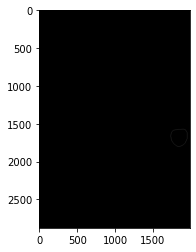

In [ ]:
im = cv2.imread(df_['mask'][200])
plt.imshow(im)
x = im[np.where(im > 0 )]
len(x[np.where(x == 1)] )

In [ ]:
#@title C MLPTrain
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import tensorflow_addons as tfa
# from WideResnet import WideResnet
from copy import deepcopy
import sklearn
from sklearn import preprocessing
import tensorflow_datasets as tfds

# import config
# from Model import Wrn28k
# from UdaCrossEntroy import UdaCrossEntroy
# from learningRate import LearningRate
# from Dataset import label_image
# from Dataset import unlabel_image
# from Dataset import merge_dataset
# from test import test





if __name__ == '__main__':
    AUTOTUNE = tf.data.experimental.AUTOTUNE

    # 有标签的数据集 batch_size=BATCH_SIZE
    # df_label = pd.read_csv(LABEL_FILE_PATH)
    # le = preprocessing.LabelEncoder()
    # dfc_['label'] = le.fit_transform(dfc_.label.values)

    u_file_paths = []
    u_labels = []
    for i in range(0, len(data)): 
      path = root + data["fullPath"][i]#2499
      path = path.replace('\\', '/')
      path = path.replace('.png', '.jpg')
      u_file_paths.append(path)
      if data["Status"][i] =="Cancer":
        u_labels.append(3)
      elif data["Status"][i] == "Normal":
        u_labels.append(1)
      elif data["Status"][i] == "Benign" :
        u_labels.append(2)
  
    train_dfc_ = df_[:int(len(dfc_)*0.7)] 
    test_dfc_ = df_[-int(len(dfc_)*0.7):]
    t_file_paths = test_dfc_['image'].values
    t_labels = test_dfc_['mask'].values
    file_paths = train_dfc_['mask'].values
    labels = train_dfc_['mask'].values

    
    ds_label_train = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds_label_train = ds_label_train \
        .map(label_image, num_parallel_calls=AUTOTUNE) \
        .shuffle(buffer_size=1000) \
        .batch(BATCH_SIZE, drop_remainder=True) \
        .prefetch(AUTOTUNE)

    # 无标签的数据集 batch_size=BATCH_SIZE*UDA_DATA
    # df_unlabel = pd.read_csv(UNLABEL_FILE_PATH)
    # file_paths = df_unlabel['name'].values
    # labels = df_unlabel['label'].values
    ds_unlabel_train = tf.data.Dataset.from_tensor_slices((u_file_paths, u_labels))
    ds_unlabel_train = ds_unlabel_train \
        .map(unlabel_image, num_parallel_calls=AUTOTUNE) \
        .shuffle(buffer_size=1000) \
        .batch(BATCH_SIZE * UDA_DATA, drop_remainder=True) \
        .prefetch(AUTOTUNE)

    # 将有标签数据和无标签数据整合成最终的数据形式
    ds_train = tf.data.Dataset.zip((ds_label_train, ds_unlabel_train))
    ds_train = ds_train.map(merge_dataset)

    # 构建teacher模型
    if TEA_CONTINUE:
        print('continue teacher training')
        teacher = classifiert#efficientunet.get_efficient_unet_b0(input_shape, pretrained=False)
        teacher.load_weights(TEA_LOAD_PATH)
        teacher.training = True
    else:
        # teacher = Wrn28k(num_inp_filters=3, k=2)
        teacher =  classifiert#efficientunet.get_efficient_unet_b0(input_shape, pretrained=False)

    # 构建student模型
    if STD_CONTINUE:
        print('continue student training')
        student =  classifier#efficientunet.get_efficient_unet_b0(input_shape,  pretrained=False)
        student.load_weights(STD_LOAD_PATH)
        student.training = True
        # student = tf.saved_model.load(STD_LOAD_PATH)
    else:
        # student = Wrn28k(num_inp_filters=3, k=2)
        student =  classifier#efficientunet.get_efficient_unet_b0(input_shape, pretrained=False)
    student_ = student.weights

    # 定义teacher的损失函数，损失函数之一为UdaCrossEntroy
    mpl_loss = tf.losses.CategoricalCrossentropy(
        reduction=tf.losses.Reduction.NONE,
        from_logits=True,
    )
    # 定义student的损失函数， PS：teacher的损失函数为UdaCrossEntroy
    s_unlabel_loss = tf.losses.CategoricalCrossentropy(
        label_smoothing=LABEL_SMOOTHING,
        from_logits=True,
        reduction=tf.keras.losses.Reduction.NONE,
    )

    # s_label_loss = tf.losses.CategoricalCrossentropy(
    #     from_logits=True,
    #     label_smoothing=LABEL_SMOOTHING,
    #     reduction=keras.losses.Reduction.NONE,)
    # tf.keras.losses.SparseCategoricalCrossentropy(
    #     from_logits=True, 
    #     reduction=keras.losses.Reduction.NONE,
    # )

    # 定义teacher的学习率
    Tea_lr_fun = LearningRate(
        TEACHER_LR,
        TEACHER_LR_WARMUP_STEPS,
        TEACHER_NUM_WAIT_STEPS
    )
    # 定义student的学习率
    Std_lr_fun = LearningRate(
        STUDENT_LR,
        STUDENT_LR_WARMUP_STEPS,
        STUDENT_LR_WAIT_STEPS
    )

    global_step = 62*CONTINUE_EPOCH
    print(f'start training from global step {global_step}......')
    TBacc = 0.78
    Tacc = 0
    SBacc = 0.31
    Sacc = 0
    epochs = MAX_EPOCHS - CONTINUE_EPOCH
    for epoch in range(epochs):
        TLOSS = 0
        TLOSS_1 = 0
        TLOSS_2 = 0
        TLOSS_3 = 0
        SLOSS = 0
        for batch_idx, (l_images, l_labels, ori_images, aug_images) in enumerate(ds_train):
            global_step += 1
            all_images = tf.concat([l_images, ori_images, aug_images], axis=0)  # shape [15, 32, 32, 3]
            u_aug_and_l_images = tf.concat([aug_images, l_images], axis=0)
            # step1：经过teacher，得到输出
            with tf.GradientTape() as t_tape:
                output = teacher(all_images)  # shape=[15, 10]
                logits, labels, masks, cross_entroy = UdaCrossEntroy(output, l_labels, global_step)
            # step2：1st call student -----------------------------
            with tf.GradientTape() as s_tape:
                logits['s_on_aug_and_l'] = student(u_aug_and_l_images)  # shape=[8, 10]
                logits['s_on_u'], logits['s_on_l_old'] = tf.split(
                    logits['s_on_aug_and_l'],
                    [aug_images.shape[0], l_images.shape[0]],
                    axis=0
                )
                cross_entroy['s_on_u'] = s_unlabel_loss(
                    y_true=tf.stop_gradient(tf.nn.softmax(logits['aug'], -1)),
                    y_pred=logits['s_on_u']
                )
                # 计算损失函数
                cross_entroy['s_on_u'] = tf.reduce_sum(cross_entroy['s_on_u']) / \
                                         tf.convert_to_tensor(BATCH_SIZE * UDA_DATA, dtype=tf.float32)
                SLOSS += cross_entroy['s_on_u']
                # for taylor
                cross_entroy['s_on_l_old'] = loss(
                    labels['l'],
                    logits['s_on_l_old']
                )

                cross_entroy['s_on_l_old'] = tf.reduce_sum(cross_entroy['s_on_l_old']) / \
                                             tf.convert_to_tensor(BATCH_SIZE, dtype=tf.float32)
            # 反向传播，更新student的参数-------
            StudentLR = Std_lr_fun.__call__(global_step=global_step)
            StdOptim = keras.optimizers.SGD(
                learning_rate=StudentLR,
                momentum=0.9,
                nesterov=True,
                # weight_decay=5e-4,
            )
            # StdOptim = keras.optimizers.Adam(learning_rate=StudentLR)
            GStud_unlabel = s_tape.gradient(cross_entroy['s_on_u'], student.trainable_variables)
            GStud_unlabel, _ = tf.clip_by_global_norm(GStud_unlabel, GRAD_BOUND)
            StdOptim.apply_gradients(zip(GStud_unlabel, student.trainable_variables))
            # 如何更新参数
            student, student_ = my_update(student, student_)

            # step3: 2nd call student ------------------------------
            logits['s_on_l_new'] = student(l_images)
            cross_entroy['s_on_l_new'] = loss(
               labels['l'],
               logits['s_on_l_new']
            )
            cross_entroy['s_on_l_new'] = tf.reduce_sum(cross_entroy['s_on_l_new']) / \
                                         tf.convert_to_tensor(BATCH_SIZE, dtype=DTYPE)
            dot_product = cross_entroy['s_on_l_new'] - cross_entroy['s_on_l_old']
            limit = 3.0**(0.5)
            moving_dot_product = tf.random_uniform_initializer(minval=-limit, maxval=limit)(shape=dot_product.shape)
            moving_dot_product = tf.Variable(initial_value=moving_dot_product, trainable=False, dtype=DTYPE)
            moving_dot_product_update = moving_dot_product.assign_sub(0.01 * (moving_dot_product - dot_product))
            dot_product = dot_product - moving_dot_product
            dot_product = tf.stop_gradient(dot_product)
            # step4: 求teacher的损失函数
            with t_tape:
                # label = tf.math.argmax(tf.nn.softmax(logits['aug'], axis=-1), axis=-1)
                # label = tf.raw_ops.OneHot(indices=label, depth=NUM_CLASSES, on_value=1.0, off_value=0)
                cross_entroy['mpl'] = mpl_loss(
                    # y_true=tf.stop_gradient(label),
                    y_true=tf.stop_gradient(tf.nn.softmax(logits['aug'], axis=-1)),
                    y_pred=logits['aug']
                )  # 恒正
                cross_entroy['mpl'] = tf.reduce_sum(cross_entroy['mpl']) / \
                                      tf.convert_to_tensor(BATCH_SIZE * UDA_DATA, dtype=DTYPE)
                uda_weight = UDA_WEIGHT * tf.math.minimum(
                    1., tf.cast(global_step, DTYPE) / float(UDA_STEPS)
                )
                # if StudentLR == 0:
                #     dot_product = 0
                teacher_loss = cross_entroy['u'] * uda_weight + \
                               cross_entroy['l'] + \
                               cross_entroy['mpl'] * dot_product

                TLOSS += teacher_loss
                TLOSS_1 += (cross_entroy['u'] * uda_weight)
                TLOSS_2 += cross_entroy['l']
                TLOSS_3 += cross_entroy['mpl'] * dot_product
            # 反向传播，更新teacher的参数-------
            TeacherLR = Tea_lr_fun.__call__(global_step=global_step)
            TeaOptim = keras.optimizers.SGD(
                learning_rate=TeacherLR,
                momentum=0.9,
                nesterov=True,
                # weight_decay=5e-4,
            )
            # TeaOptim = keras.optimizers.Adam(learning_rate=TeacherLR)
            GTea = t_tape.gradient(teacher_loss, teacher.trainable_variables)
            GTea, _ = tf.clip_by_global_norm(GTea, GRAD_BOUND)
            TeaOptim.apply_gradients(zip(GTea, teacher.trainable_variables))

            if (batch_idx + 1) % LOG_EVERY == 0:
                TLOSS = TLOSS / LOG_EVERY
                TLOSS_1 = TLOSS_1 / LOG_EVERY
                TLOSS_2 = TLOSS_2 / LOG_EVERY
                TLOSS_3 = TLOSS_3 / LOG_EVERY
                SLOSS = SLOSS / LOG_EVERY
                print(f'global: %4d' % global_step + ',[epoch:%4d/' % (epoch+CONTINUE_EPOCH) + 'EPOCH: %4d] \t' % epochs
                      + '[U:%.4f' % (TLOSS_1) + ', L:%.4f' % (TLOSS_2) + ', M:%.4f' % (
                          TLOSS_3) + ']' + '[TLoss: %.4f]' % TLOSS + '/[SLoss: %.4f]' % SLOSS
                      + '\t[TLR: %.6f' % TeacherLR + ']/[SLR: %.6f]' % StudentLR)
                TLOSS = 0
                TLOSS_1 = 0
                TLOSS_2 = 0
                TLOSS_3 = 0
                SLOSS = 0
        # 测试teacher在test上的acc
        if epoch % 5 == 0:
            Tacc = test(teacher, t_file_paths, t_labels)
            print(f'testing teacher model ... acc: {Tacc}')
        # 测试student在test上的acc，当student开始训练的时候
        if (StudentLR > 0) and (epoch % 5 == 0):
            Sacc = test(student, t_file_paths, t_labels)
            print(f'testing ... acc: {Sacc}')
        # 保存weights
        if Tacc > TBacc:
            Tsave_path = TEA_SAVE_PATH  # + str(epoch + 1) + '_' + str(batch_idx + 1)
            teacher.save_weights(Tsave_path)
            # tf.saved_model.save(teacher, Tsave_path)
            TBacc = Tacc
            print(f'saving for TBacc {TBacc}, Tpath:{Tsave_path}')
        if Sacc > SBacc:
            Ssave_path = STD_SAVE_PATH  # + str(epoch + 1) + '_' + str(batch_idx + 1)
            student.save_weights(Ssave_path)
            SBacc = Sacc
            print(f'saving for SBacc {SBacc}, Spath:{Ssave_path}')

continue teacher training


KeyboardInterrupt: ignored

In [ ]:
teacher.save_weights('/content/drive/MyDrive/Thesis/weights/ST')

In [ ]:
student.save_weights('/content/drive/MyDrive/Thesis/weights/SS')

In [ ]:
test(student, t_file_paths, t_labels)

tf.Tensor(
[[[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]], shape=(1, 448, 448, 1), dtype=float32)


InvalidArgumentError: ignored